In [1]:
#
# Copyright (c) 2021, NVIDIA CORPORATION. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

### Check the TensorRT version

In [1]:
!python3 -c 'import tensorrt; print("TensorRT version: {}".format(tensorrt.__version__))'

TensorRT version: 8.4.1.5


In [2]:
!pip install matplotlib

     |################################| 11.5 MB 393 kB/s            
     |################################| 1.1 MB 1.1 MB/s             


### Import required modules

In [1]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
import time
import matplotlib.pyplot as plt
from PIL import Image

TRT_LOGGER = trt.Logger()

# Filenames of TensorRT plan file and input/output images.
engine_file = "transfusion_head.engine"
input_file  = "images/bulbul.jpg"
output_file = "output.ppm"

### Utilities for input / output processing

In [6]:
# For torchvision models, input images are loaded in to a range of [0, 1] and
# normalized using mean = [0.485, 0.456, 0.406] and stddev = [0.229, 0.224, 0.225].
def preprocess(image):
    # Mean normalization
    # mean = np.array([0.485, 0.456, 0.406]).astype('float32')
    # stddev = np.array([0.229, 0.224, 0.225]).astype('float32')
    # data = (np.asarray(image).astype('float32') / float(255.0) - mean) / stddev
    # Switch from HWC to to CHW order
    # return np.moveaxis(data, 2, 0)
    data = np.asarray(image).astype('float32') / float(255.0)
    return np.moveaxis(data, 2, 0)

def postprocess(data):
    num_classes = 21
    # create a color palette, selecting a color for each class
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([palette*i%255 for i in range(num_classes)]).astype("uint8")
    # plot the segmentation predictions for 21 classes in different colors
    img = Image.fromarray(data.astype('uint8'), mode='P')
    img.putpalette(colors)
    return img


### Load TensorRT engine

Deserialize the TensorRT engine from specified plan file. 

In [2]:
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

### Inference pipeline

Starting with a deserialized engine, TensorRT inference pipeline consists of the following steps:
- Create an execution context and specify input shape (based on the image dimensions for inference).
- Allocate CUDA device memory for input and output.
- Allocate CUDA page-locked host memory to efficiently copy back the output.
- Transfer the processed image data into input memory using asynchronous host-to-device CUDA copy.
- Kickoff the TensorRT inference pipeline using the asynchronous execute API.
- Transfer the segmentation output back into pagelocked host memory using device-to-host CUDA copy.
- Synchronize the stream used for data transfers and inference execution to ensure all operations are completes.
- Finally, write out the segmentation output to an image file for visualization.

In [11]:
def infer(engine, input_file, output_file):
    # print("Reading input image from file {}".format(input_file))
    with Image.open(input_file) as img:
        img = img.resize((224,224)) # for specific model
        input_image = preprocess(img)
        image_width = img.width
        image_height = img.height

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input"), (1, 3, image_height, image_width))
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_image)
                input_memory = cuda.mem_alloc(input_buffer.nbytes) # I made one change
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))
        time_trt = []
        total_trt = 0
        for i in range (0, 100):
            stream = cuda.Stream()
            start_t = time.time()
            # Transfer input data to the GPU.
            cuda.memcpy_htod_async(input_memory, input_buffer, stream)
            # Run inference
            context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
            # Transfer prediction output from the GPU.
            cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
            # Synchronize the stream
            stream.synchronize()
            end_t = time.time()
            time_trt.append(end_t - start_t)
            total_trt += time_trt[i]
        print(time_trt[:10])
        print("average time cost:", total_trt * 10, "ms")
#     with postprocess(np.reshape(output_buffer, (image_height, image_width))) as img:
#         print("Writing output image to file {}".format(output_file))
#         img.convert('RGB').save(output_file, "PPM")
    return output_buffer

In [3]:
def infer(engine, input_file):

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input"), (1, 3, image_height, image_width))
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_file)
                input_memory = cuda.mem_alloc(input_buffer.nbytes) # I made one change
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))
        time_trt = []
        total_trt = 0
        for i in range (0, 1):
            stream = cuda.Stream()
            start_t = time.time()
            # Transfer input data to the GPU.
            cuda.memcpy_htod_async(input_memory, input_buffer, stream)
            # Run inference
            context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
            # Transfer prediction output from the GPU.
            cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
            # Synchronize the stream
            stream.synchronize()
            end_t = time.time()
            time_trt.append(end_t - start_t)
            total_trt += time_trt[i]
        print(time_trt[:10])
        print("average time cost:", total_trt * 10, "ms")

    return output_buffer

### Run inference

In [8]:
print("Running TensorRT inference for Swin-Transformer")
with load_engine(engine_file) as engine:
    result = infer(engine, input_file, output_file)

Running TensorRT inference for Swin-Transformer
Reading engine from file sample.engine
[0.0031578540802001953, 0.0031299591064453125, 0.0031201839447021484, 0.0031239986419677734, 0.003123044967651367, 0.003123760223388672, 0.003122091293334961, 0.003125429153442383, 0.0031244754791259766, 0.003124237060546875]
average time cost: 2.9581785202026367 ms


In [4]:
import torch
head_metas = torch.load('head_metas.pt').cpu()
input_metas = head_metas.detach().numpy()

In [10]:
print("Running TensorRT inference for Swin-Transformer")
with load_engine(engine_file) as engine:
    result = infer(engine, input_metas)

Running TensorRT inference for Swin-Transformer


NameError: name 'load_engine' is not defined

In [2]:
engine_file = "transfusion_head.engine"
assert os.path.exists(engine_file)
print("Reading engine from file {}".format(engine_file))
with open(engine_file, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
    engine = runtime.deserialize_cuda_engine(f.read())

Reading engine from file transfusion_head.engine


In [3]:
print(engine)

None


### Plot input image

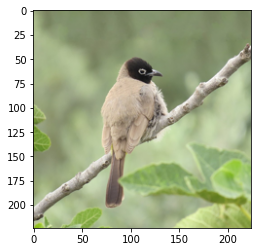

In [10]:
with Image.open(input_file) as img:
    img = img.resize((224,224))
    data = np.asarray(img).astype('float32') / float(255.0)
    data = np.moveaxis(data, 2, 0)
    plt.imshow(img)

In [13]:
import onnxruntime as ort
import numpy as np

ort_sess = ort.InferenceSession('Swin_T.onnx',providers=['CUDAExecutionProvider'])
time_onnx = []
total_onnx = 0
for i in range(0, 100):
    start_t = time.time()
    outputs = ort_sess.run(None, {'input': np.expand_dims(data, axis=0)})
    end_t = time.time()
    time_onnx.append(end_t - start_t)
    total_onnx += time_onnx[i]
print("average time cost:", total_onnx * 10, "ms")
print(np.argmax(outputs))

average time cost: 3.903820514678955 ms
16


In [8]:
print(ort.get_device())

GPU


### Plot segmentation output

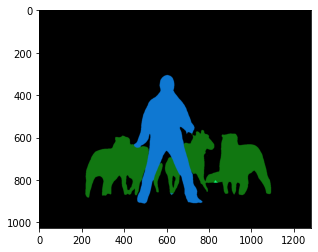

In [9]:
plt.imshow(Image.open(output_file))